# Sentence processing with large language models


This first part of the exercise aims to take advantage of large language models to compute basic information theoretic measures related to reading time analysis. Our goal is to compute surprisals for the tokens of the sentences.


This set of exercises introduces practically to prompting large language models with the huggingface environment. [Hugging face](https://huggingface.co/) is a company that hosts most language models and data sets currently used by the AI community. It aims to provide a high level access to these models and data sets, saving end users from the lower level implementation details. It targets machine learning users and experimentalists. Those that are more interested in designing their own models should look at [pytorch](https://pytorch.org/) or [tensorflow](https://www.tensorflow.org/?hl=fr) libraries

## Huggingface hub and access token


Huggingface is a company that provides a common programming interface to a wide array of models and data sets currently in use by the AI community. When using huggingface you are likely to download resources for which the companies request that you sign up a license.  In order to do that you have to be authenticated in the Huggingface hub. This identification procedure is programmatic and relies on an **access token** that you have to create.

To do that, you first want to create an huggingface account by signing up from the [login web page](https://huggingface.co/login). Then you want to access your profile avatar on the right top of the screen and select *Settings* in the drop down menu. Once in Settings click on *Access tokens* in the left menu and create a new **access token of type read**. As illustrated in the screenshot below. Keep the token value preciously. 

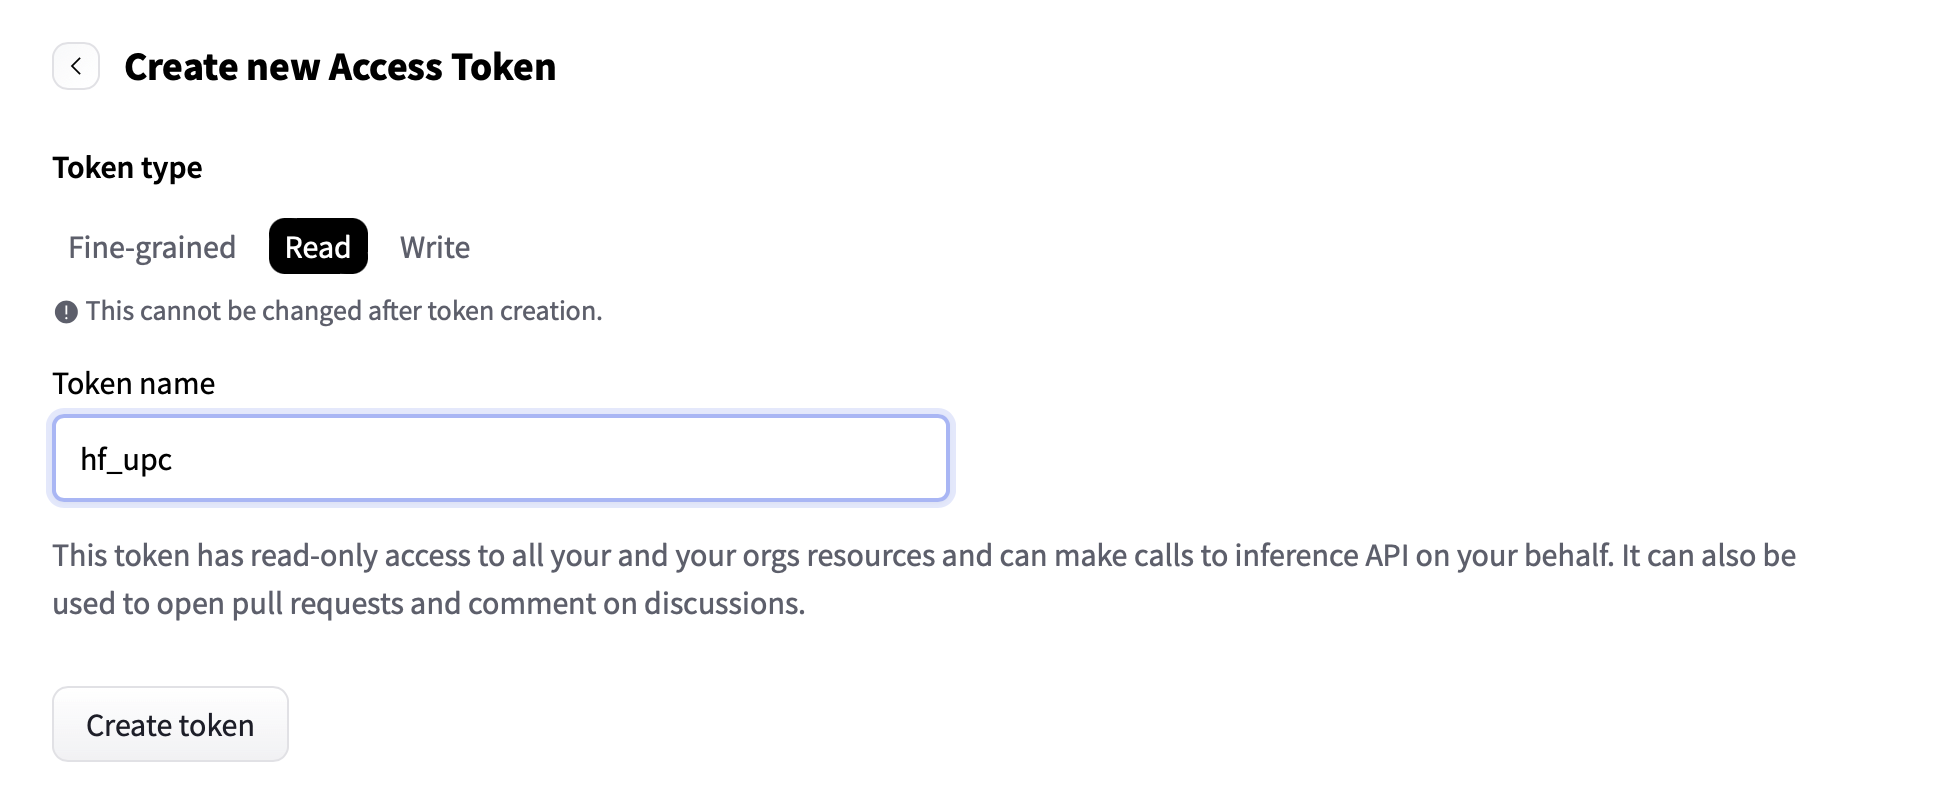

### Storing the token in an environment variable

To authenticate yourself when running your code requires to
set an [environment variable](https://en.wikipedia.org/wiki/Environment_variable).

To do that, first create a file with name `.env` in your home directory
then add the line:

> HUGGINGFACEHUB_API_TOKEN=\<your_token\>

*When working on colab create the file in the google drive home directory:* `/content/drive/MyDrive`


### Accessing the token from python scripts

In [ ]:
!pip install python-dotenv --quiet

import os
from dotenv import load_dotenv

#on your local computer

load_dotenv('~/.env')
mytoken = os.environ.get('HUGGINGFACEHUB_API_TOKEN')

#on colab (you additionaly need to get access to google drive)

#from google.colab import drive
#drive.mount('/content/drive')
#load_dotenv('/content/drive/MyDrive/.env')
#mytoken = os.environ.get('HUGGINGFACEHUB_API_TOKEN')


#check that the token value is correct
print('mytoken =',mytoken)

## Loading and using GPT-2

We will use GPT-2 as it sufficiently large for this exercise and it can be used on google colab.

In [ ]:
# Basic code for loading GPT-2 and prompting it
# GPT-2 has low memory footprint (by nowadays standards ...) but should be run on colab


device    = "cuda"  # code still runs but is quite slow if set to 'cpu'
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model     = AutoModelForCausalLM.from_pretrained("gpt2", torch_dtype=torch.float16).to(device)  #we use half precision but no quantization here


# this tokenizes the string from a batch of 1 example and returns a pytorch tensor
prompt        = "What is the capital of Burma ?"
xinputs       = tokenizer(prompt, return_tensors="pt").to(device)

#This shows how the prompt text is tokenized by GPT-2
print("Visualize the tokenization")
print(tokenizer.decode(xinputs))
#Alternatively one can use
print(tokenizer.tokenize(prompt))




#Optional for this exercise. It shows how to generate a text given a prompt
#generated_ids = model.generate(**xinputs, max_new_tokens=100, do_sample=True) #samples gpt-2
#print('\nGenerated text:')
#print(tokenizer.decode(generated_ids[0]))


## Correlating surprisal with Reading times

In this exercise we will see how to correlate surprisal values from a large language model to reading times.
We use the UCL reading time data set and the first step is to load it in a Pandas dataframe. As you will see the dataset contains recording of Reading Times for a large amount of subjects. For each sentence in the data, you want to aggregate the data by averaging the subject reading times (and compute standard deviation)  

**Question 1** Once this is done you want to gather basic statistics describing the dataset, such as the number of tokens, number of sentences, reading time distribution, etc.

**Question 2** Design a function that takes as input a sentence from the corpus, runs is through GPT-2 and returns the surprisal values for each **subword** 

In [ ]:
import torch.nn as nn

def transition_probs(sentence,surprisal=False):
  example  = f"{tokenizer.bos_token} {sentence}" #we add the dummy <bos> token
  tokens   = tokenizer.tokenize(example)
  xinputs  = torch.LongTensor(tokenizer.convert_tokens_to_ids(tokens)[:-1]) #do not predict next word for the last word
  yrefs    = torch.LongTensor(tokenizer.convert_tokens_to_ids(tokens)[1:])  #removes the first token
  logits   = model(xinputs).logits                               # [seq, vocab]
  logprobs = nn.LogSoftmax(dim = -1)(logits)                     # [seq, vocab]
  logprobs = logprobs.gather(dim = 1,index = yrefs.unsqueeze(0)) # [seq]
  if surprisal:
      logprobs = -logprobs
  return list(zip(tokens[1:],logprobs.squeeze().tolist()))


print(transition_probs("Here is how GPT-2 computes its transition probabilities ."))

**Question 3** Design a function that realigns the subwords and their surprisals with the corpus tokenization. The result is a pandas dataframe where for each token we have at least the average reading time and its model surprisal 

**Question 4** Compute the correlation between the reading times and the surprisal values. Generate a scatterplot with a regression line.
Compute a linear regression and explain the result you get.

Usually, we want to test if the language model provides better predictions than baselines. To do that we put word frequencies (or word lengths) and subject IDs as predictors.  If you know how to use the R package lme4, you may also fit a mixed effect model where subject ID and word frequencies are set as random intercepts.

**Question 5** Generalize your method and compute the correlation for eye tracking measures. Which measure correlates best with model surprisal ?

## The surprisal package

**Question 6** There is as python package called `surprisal`. Read the docs and compute the surprisal values for your corpus. Do the results are the same as yours ? if not can you explain the differences ? 

**Question 7**  The surprisal package also allows the use of KenLM. What is KenLM ? what kind of models underlie KenLM ? explain and tell how different it is from GPT-2 ?